# resolving XAS from YAG screen

## loading libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
from scipy import optimize
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os
from scipy import ndimage

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [249]:
mpl.rcParams['figure.figsize'] = (16,12) 

## loading and converting data

In [55]:
#load data
experiment_run_name = "hdf5/sxr10116run24.h5"
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

In [56]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    try:
        my_dict[i] = array(my_hdf5_object[i]).astype(float)
    except (AttributeError,ValueError) as e:
        print(i)
        
pixel_to_femtosecond_list = []
width_list = []
my_hdf5_object.close()

ebeam
evr
gas_detector


## masking burnt part of yag and removing offset

In [108]:
my_mask = ones(1024).astype(bool)
my_mask[500:550]=False

In [109]:
my_dict['exs_opal']-=mean(my_dict['exs_opal'][4][900:])
my_dict['exs_opal']=my_dict['exs_opal'][:,my_mask]

## visual inspection of data

### SASE spectrum for one shot

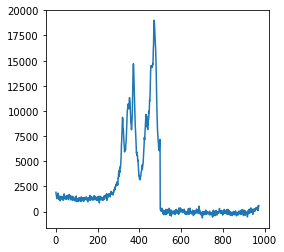

In [265]:
mpl.rcParams['figure.figsize'] = (4,4) 
plot(my_dict['exs_opal'][4])


## FEE gas detector vs shot by shot integrated SASE spectrum

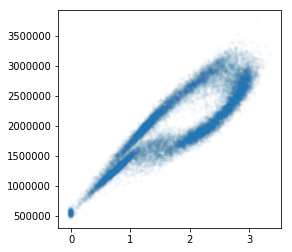

In [264]:
mpl.rcParams['figure.figsize'] = (4,4) 
plot(my_dict['gas_detector/f_12_ENRC'],sum(my_dict['exs_opal'],axis=1),'.',alpha=0.02)

## FEE gas detector vs pixel from SASE spectrum

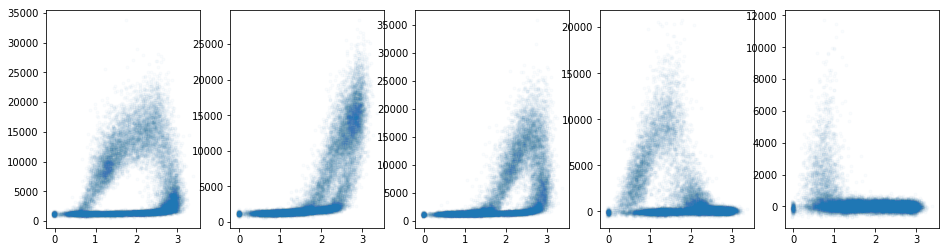

In [260]:
mpl.rcParams['figure.figsize'] = (16,4) 
pixel_list=[250,350,450,550,650]
for i in arange(len(pixel_list)):
    subplot(1,len(pixel_list),i+1)
    plot(my_dict['gas_detector/f_12_ENRC'],(my_dict['exs_opal'][:,pixel_list[i]]),'.',alpha=0.02)



## SVD dimension reduction: eigen spectra of SASE beam

In [113]:
u,s,v = svd(my_dict['exs_opal'])

### several eigen spectra

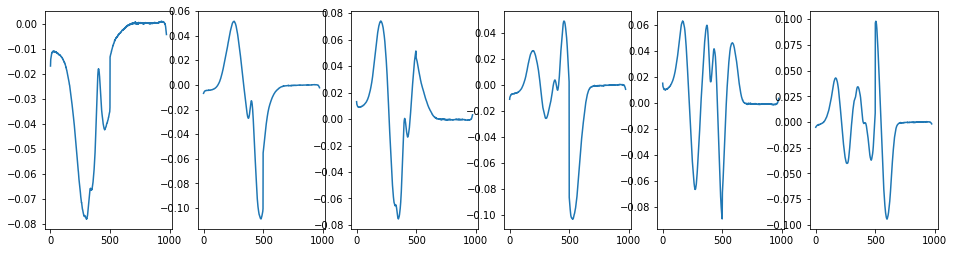

In [271]:
svd_size = 6
mpl.rcParams['figure.figsize'] = (16,4) 
for i in arange(svd_size):
    subplot(1,svd_size,i+1)
    plot(v[i])
show()
#xlim(500,550)


### eigen weights: show very interesting behavior

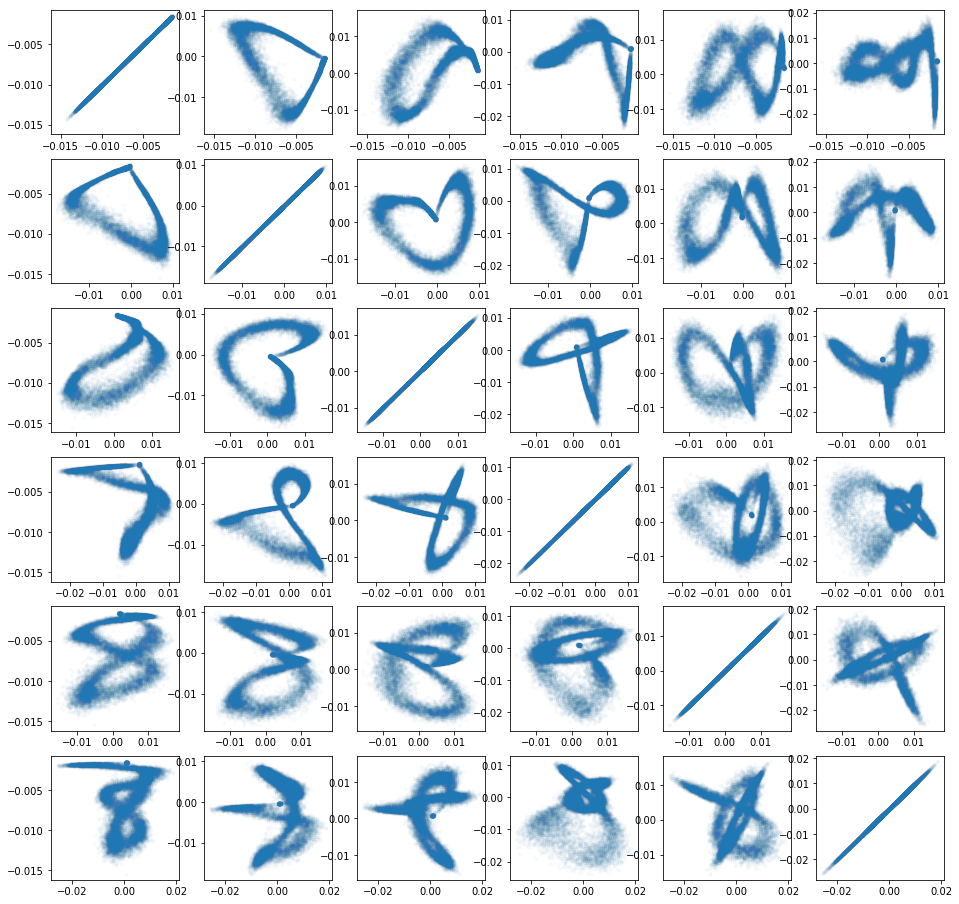

In [272]:
mpl.rcParams['figure.figsize'] = (16,16) 

for i in arange(svd_size):
    for j in arange(svd_size):
        subplot(svd_size, svd_size, svd_size*i+j+1)
        plt.plot(u[:,i],u[0:,j],'.',alpha=0.02)
show()

### eigen weights vs fee gass detector

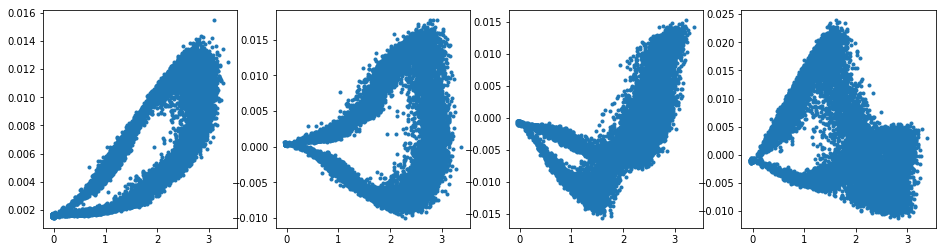

In [263]:
mpl.rcParams['figure.figsize'] = (16,4) 
for i in arange(4):
    subplot(1,4,i+1)
    plot(my_dict['gas_detector/f_12_ENRC'],-u[:,i],'.')
show()

In [ ]:
### 

In [293]:
weights = dot(u[:,:len(s)],diag(s))

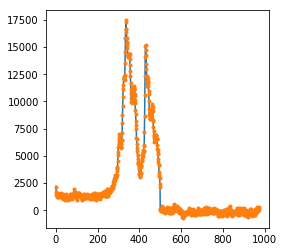

In [294]:
mpl.rcParams['figure.figsize'] = (4,4) 
reconstructed = dot(weights,v)
plot(reconstructed[100])
plot(my_dict['exs_opal'][100],'.')

## eigen fee calculation

In [213]:
eigen_fee = dot(pinv(weights),my_dict['gas_detector/f_12_ENRC'])


In [214]:
reconstructed_fee = dot(weights,array([eigen_fee]).transpose())[:,0]

In [215]:
reconstructed_fee

array([3.08685843, 2.80081075, 2.88304632, ..., 1.56623275, 1.7739137 ,
       1.76230145])

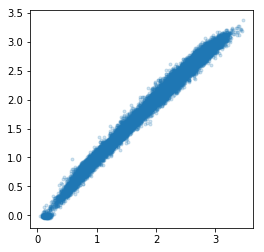

In [295]:
plot(reconstructed_fee,my_dict['gas_detector/f_12_ENRC'],'.',alpha=0.2)

## Forward model

In [ ]:
import numpy as np

a = np.arange(10)
a = np.vstack((a,a)).T

filt = np.ones(3)

np.apply_along_axis(lambda m: np.convolve(m, filt, mode='full'), axis=0, arr=a)

In [366]:
sase_mask = rand(10000,1024)<0.993
sase_sim  =  rand(10000,1024)*exp(-(cumsum(ones([10000,1024]),axis=1)-512)**2/(250**2))

#sase_sim effect of edge
edge = convolve(ones(1024)+6*ones(1024),ones(20),mode='same')
my_kernel = exp(-(arange(200)-50)**2/(25**2))
sase_sim[sase_mask] = 0

sase_sim = apply_along_axis(lambda m: convolve(m,my_kernel,mode='same'),axis=1,arr=sase_sim)

In [368]:
cumsum(ones([10000,1024]),axis=1)-rand(1024)

array([[5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03],
       [5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03],
       [5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03],
       ...,
       [5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03],
       [5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03],
       [5.52118158e-01, 1.81894983e+00, 2.96258487e+00, ...,
        1.02177971e+03, 1.02268199e+03, 1.02347927e+03]])

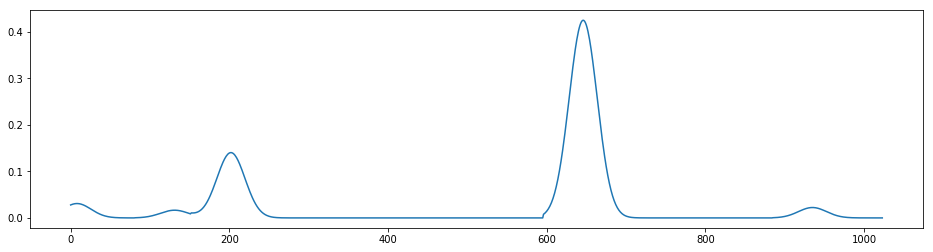

In [369]:
mpl.rcParams['figure.figsize'] = (16,4) 
plot(sase_sim[100])

In [370]:
u,s,v = svd(sase_sim)

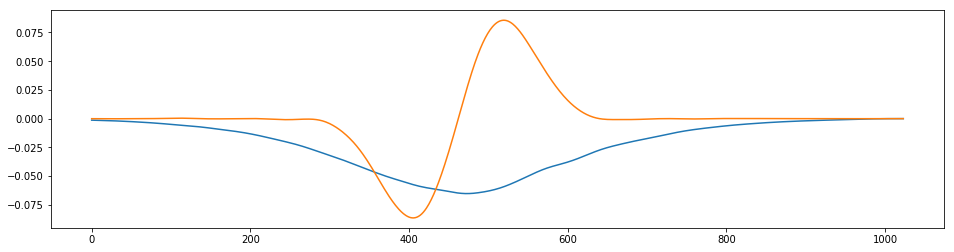

In [371]:
plot(v[0])
plot(v[1])

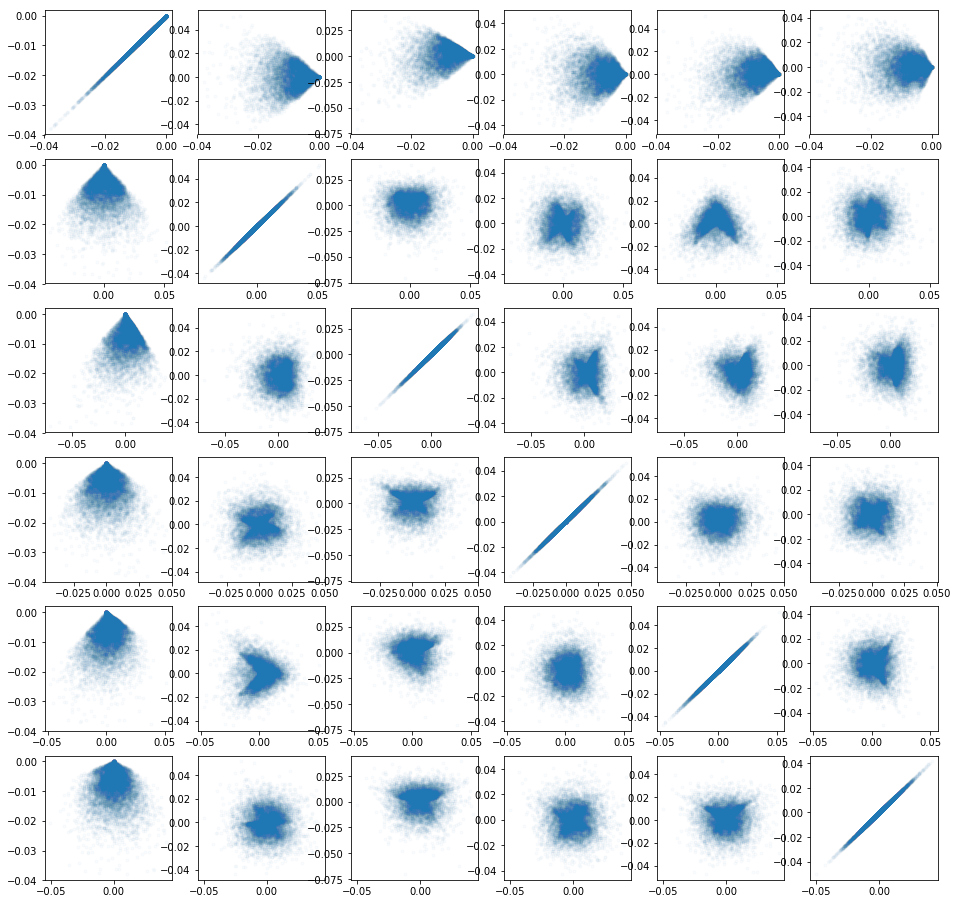

In [372]:
mpl.rcParams['figure.figsize'] = (16,16) 

for i in arange(svd_size):
    for j in arange(svd_size):
        subplot(svd_size, svd_size, svd_size*i+j+1)
        plt.plot(u[:,i],u[:,j],'.',alpha=0.02)
show()

In [348]:
sase_mask = rand(10000,1024)<0.993
sase_sim  =  rand(10000,1024)*exp(-(arange(1024)-512)**2/(250**2))
#sase_sim effect of edge
edge = convolve(ones(1064)+6*heaviside(arange(-432,632),1),ones(20),mode='same')[20:1044]
my_kernel = exp(-(arange(200)-50)**2/(25**2))
sase_sim[sase_mask] = 0

sase_sim = apply_along_axis(lambda m: convolve(m,my_kernel,mode='same'),axis=1,arr=sase_sim)

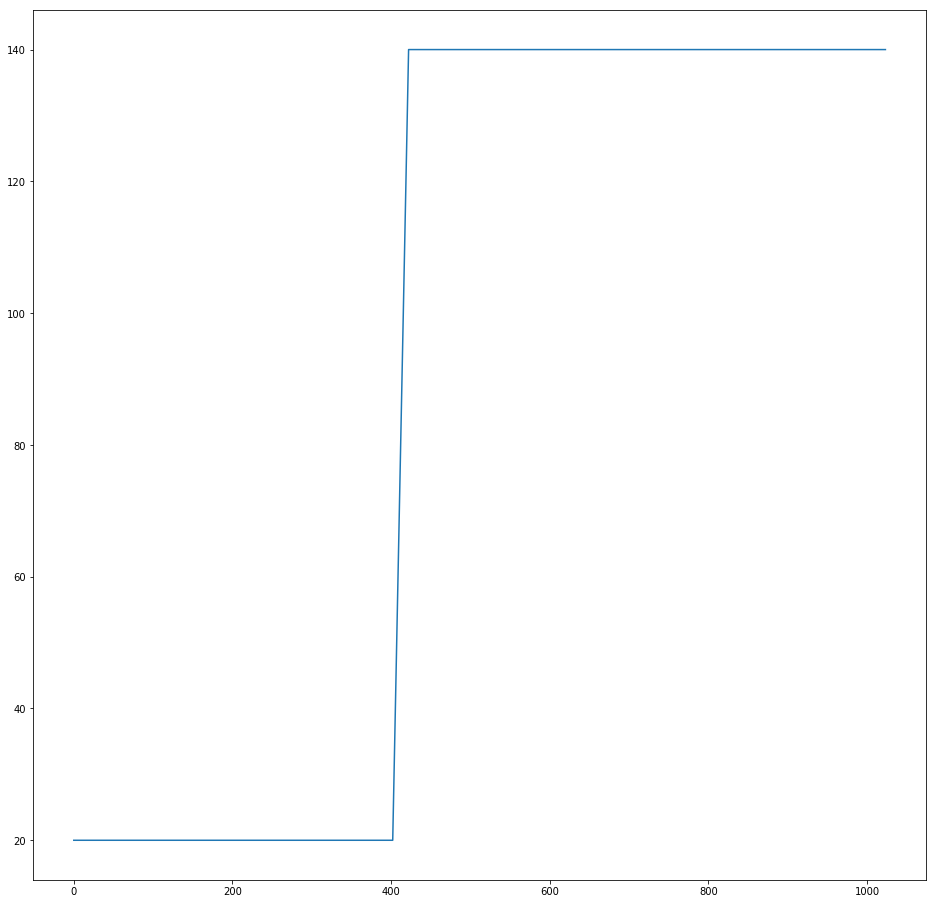

In [349]:
plot(edge)

In [350]:
u,s,v = svd(sase_sim)

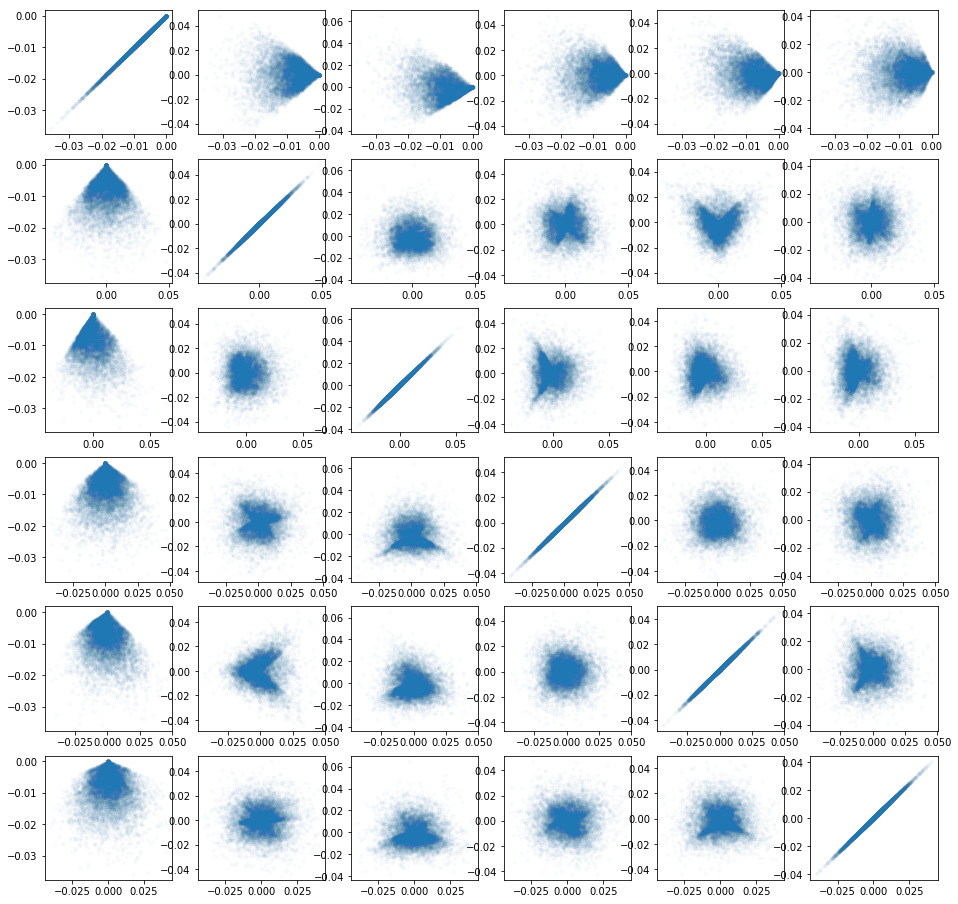

In [351]:
mpl.rcParams['figure.figsize'] = (16,16) 

for i in arange(svd_size):
    for j in arange(svd_size):
        subplot(svd_size, svd_size, svd_size*i+j+1)
        plt.plot(u[:,i],u[:,j],'.',alpha=0.02)
show()